### Содержание

1. [Как получать контекст последовательности с помощью pyfaidx](#Как-получать-контекст-последовательности-с-помощью-pyfaidx)
2. [Подготовка датафреймов](#Подготовка-датафреймов)  
   2.1 [Фильтруем общий датафрейм](#Фильтруем-общий-датафрейм)  
   2.2 [Добавляем метрику LOEUF](#Добавляем-метрику-LOEUF)
3. [Разделение вариантов по значению патогенности](#Разделение-вариантов-по-значению-патогенности)  
   3.1 [Разделение по AC и LOEUF](#Разделение-по-AC-и-LOEUF)  
   3.2 [Убираем из условно доброкачественных вариантов все паты по Clinvar](#Убираем-из-условно-доброкачественных-вариантов-все-паты-Clinvar)  
   3.3 [Добавляем в условно патогенные варианты все непопуляционные паты Clinvar](#Добавляем-в-условно-патогенные-варианты-все-непопуляционные-паты-Clinvar)  
4. [Получение контекста последовательности](#Получение-контекста-последовательности)  
5. [Построение лого с помощью logomaker](#Построение-лого-с-помощью-logomaker)  
6. [Статистическое сравнение позиций в контекстах](#Статистическое-сравнение-позиций-в-контекстах)  

In [1]:
import logomaker as lm
import numpy as np
import pandas as pd
import seqlogo

from pyfaidx import Fasta
from scipy.stats import chi2_contingency
from os.path import join

### Как получать контекст последовательности с помощью pyfaidx

In [2]:
# TODO

In [3]:
DATA_PATH = "data_dir"

https://pypi.org/project/pyfaidx/

Загружаем нашу фасту с транскриптами, на этом этапе создается индекс fai.  

Дополнительно кастомизируем ключи, т.к. в файле траснкриптов ключи выглядят так:  
`ENST00000353265.8|ENSG00000178184.16|OTTHUMG00000132922.4|OTTHUMT00000256435.3|PARD6G-201|PARD6G|3836|protein_coding|`  
А нам нужна только их первая часть.

Тут бесячий момент: надо переархивировать файл с транскриптами в BGZF  
_Compressed FASTA is only supported in BGZF format. Use the samtools bgzip utility (instead of gzip) to compress your FASTA._  

<font color='brown'> Похоже, важно иметь версию >0.7.0, т.к. с ней какие-то проблемы: несмотря на перевод файла в BGZF формат, ошибка о неправильно инпуте не пропадала. А после апдейта до v.0.8.1.1 всё сработало.

In [4]:
transcript_fasta = Fasta(join(DATA_PATH, "transcript_fasta/gencode.v45.transcripts.fa.gz"), key_function = lambda x: x.split('.')[0])

Интересующий транскрипт и позиция:

In [5]:
transcript_id = 'ENST00000353265'
position_of_interest = 34

In [6]:
len(transcript_fasta[transcript_id])

3836

Индексация с 0, поэтому чтобы получить позицию 34, вводим 33:

In [7]:
transcript_fasta[transcript_id][33]

>ENST00000353265:34-34
C

Утилита работает как словарь, тогда по примеру из документации:

In [8]:
transcript_fasta[transcript_id][position_of_interest - 5 : position_of_interest + 5].complement

>ENST00000353265:30-39 (complement)
CGTCGTGGCC

Тут вызвали комплементарную позицию.

In [9]:
sequence = 'CGTCGTGGCC'

In [10]:
for i, nucleotide in enumerate(sequence, 30):
    print(f"{i} - {nucleotide}")

30 - C
31 - G
32 - T
33 - C
34 - G
35 - T
36 - G
37 - G
38 - C
39 - C


Проверила глазами по таблице, всё сходится.

### Подготовка датафреймов

Преобразуем имеющиеся таблицы в датафреймы и объединяем всё в один датафрейм.

In [11]:
chromosomes = ['chr' + str(i) for i in range(1, 23)]
frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]

final_df = pd.concat(frames)

/tmp/ipykernel_1368561/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1368561/1917723234.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1368561/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1368561/1917723234.py:2: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exom

In [12]:
final_df.shape

(67528142, 14)

In [13]:
final_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Impact                  object
Consequence             object
Gene_symbol             object
Canonical_transcript    object
cDNA_position           object
LoF                     object
LoF_flag                object
LoF_filter              object
AC                       int64
dtype: object

In [14]:
final_df = final_df.rename(columns={'Chr': 'CHROM', 'Position': 'POS', 'Ref': 'REF', 'Alt': 'ALT'})

In [15]:
final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
0,chr1,12541,.,C,G,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,1
1,chr1,12591,rs1553119381,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
2,chr1,12592,.,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
3,chr1,12599,rs1437963543,CT,C,"LOW, MODIFIER, MODIFIER",splice_polypyrimidine_tract_variant&intron_var...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,14
4,chr1,12612,rs1205998786,GGT,G,"LOW, MODIFIER, MODIFIER",splice_region_variant&non_coding_transcript_ex...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",98-99,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621633,chr22,50799702,rs4081531,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,377
1621634,chr22,50799821,rs149733995,A,C,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,11
1621635,chr22,50801218,rs368061391,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,1
1621636,chr22,50801236,rs113976139,C,G,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,18


#### Фильтруем общий датафрейм

Оставляем только однонуклеотидные стопгейны.

In [16]:
filtered_df = final_df[~final_df['Consequence'].astype(str).str.contains(',')]
lof_final_df = filtered_df[filtered_df['Consequence'].str.contains('stop_gained', na=False)]
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


In [17]:
lof_final_df['POS'].nunique()

314859

#### Добавляем метрику LOEUF

Для этого сначала переводим скачанный файл с метриками в датафрейм.

In [18]:
lof_metrics_by_gene = pd.read_table('../raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
lof_metrics_by_gene

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,...,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,...,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,protein_coding,1038,7.093800e-03,3.0,2.9635,1.012300,NaN,19,9212945,9213982
19700,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,protein_coding,939,4.059600e-01,1.0,4.8401,0.206610,NaN,19,9236688,9237626
19701,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,protein_coding,1026,2.159200e-01,1.0,2.7436,0.364480,NaN,11,124179708,124180733
19702,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,protein_coding,22597,1.477300e-13,16.0,9.6420,1.659400,NaN,19,53267448,53290044


In [19]:
lof_metrics_by_gene.columns.get_loc('oe_lof_upper')

29

Создаем словарь "транскрипт": "значение_loeuf".

In [20]:
loeuf_by_transcript_dict = dict(zip(lof_metrics_by_gene['transcript'], lof_metrics_by_gene['oe_lof_upper']))

In [21]:
loeuf_by_transcript_dict

{'ENST00000397786': 0.03,
 'ENST00000282516': 0.032,
 'ENST00000361804': 0.037,
 'ENST00000317147': 0.038,
 'ENST00000372771': 0.04,
 'ENST00000298281': 0.04,
 'ENST00000336824': 0.042,
 'ENST00000276072': 0.043,
 'ENST00000308488': 0.044,
 'ENST00000360982': 0.044,
 'ENST00000529006': 0.045,
 'ENST00000263377': 0.048,
 'ENST00000358691': 0.048,
 'ENST00000316623': 0.049,
 'ENST00000401558': 0.051,
 'ENST00000418929': 0.051,
 'ENST00000324545': 0.051,
 'ENST00000379059': 0.051,
 'ENST00000418600': 0.052,
 'ENST00000314191': 0.052,
 'ENST00000345617': 0.052,
 'ENST00000446231': 0.053,
 'ENST00000253048': 0.054,
 'ENST00000371817': 0.055,
 'ENST00000429416': 0.055,
 'ENST00000337273': 0.056,
 'ENST00000373204': 0.057,
 'ENST00000404338': 0.057,
 'ENST00000243077': 0.058,
 'ENST00000361337': 0.059,
 'ENST00000283943': 0.06,
 'ENST00000311117': 0.06,
 'ENST00000310441': 0.06,
 'ENST00000302904': 0.06,
 'ENST00000342160': 0.06,
 'ENST00000314358': 0.06,
 'ENST00000359863': 0.06,
 'ENST00000

Запишем в столбец LOEUF все совпадения по ключам-транскриптам.

In [22]:
lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)

/tmp/ipykernel_1368561/2571592718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)


In [23]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1,NaN
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1,NaN
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1,NaN
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2,NaN
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173,NaN
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1,NaN
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1,NaN
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2,NaN


Посмотрим, какие значения записались и сверим, совпадает ли с исходным файлом **(upd: да)**

In [24]:
lof_final_df[lof_final_df['LOEUF'].notna()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13271,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1,1.327
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880


In [25]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000327044', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000216139', 'oe_lof_upper'].values[0])

1.327 
 0.88


In [26]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000370783', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000262213', 'oe_lof_upper'].values[0])

0.361 
 0.361


### Разделение вариантов по значению патогенности

Для начала создадим датафреймы для пат/непат (условно).  
  
Важно оставить только высококонсервативные варианты, для этого поставим отсечку по LOEUF (в гномаде 2 она составляет 0,35). Нет LOEUF - нет варианта.

Как я предлагаю это делать:  
* **условно патогенные**  
   Отсечка в AC < 2, LOEUF > 0.35. Плюс можно пересечь с ClinVar и записать в список варианты пат/лпат, которые отсутcтвуют в GnomAD v.4, но есть в ClinVar, так мы расширим список патов.
    
* **условно доброкачественные**  
  Отсечка в AC >= 2 (согласно свежим рекомендациям ACGS, критерий BS2), LOEUF > 0.35. В таком случае у нас может останться много АР вариантов, их я предлагаю убрать. Для этого можно полученный условно доброкачественный список сопоставить с ClinVar и удалить все пересечения с зарегистрированными пат/лпат вариантами.

The loss-of-function observed over expected upper bound fraction, or LOEUF score, is a metric that places each gene on a continuous scale of loss-of-function constraint. Low scores are highly correlated with disease genes and gene essentiality (https://doi.org/10.1007/s00439-022-02509-x). 
  
Due to expected shifts in the LOEUF distribution between gnomAD v2.1.1 and v4.0, we now recommend a threshold of LOEUF < 0.6 for v4.0 (compared to LOEUF < 0.35 for v2). (https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/#loeuf-guidance)

В ClinVar не указаны транскрипты, поэтому проаннотируем скачанный файл Clinvar (версия для GRCh38) с помощью vep.  
`./vep -i ../clinvar/clinvar_20240331.vcf -o ../clinvar/clinvar_20240331_anno.vcf --vcf --canonical --cache`

#### Разделение по AC и LOEUF

Разнесём общий датафрейм (`lof_final_df`) на `pat_df` и `ben_df`.

**Условно патогенные**:

In [27]:
pat_df = lof_final_df.query('AC < 2 & LOEUF > 0.35')
pat_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13271,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13699,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,HC,NaN,NaN,1,1.327
13710,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,HC,NaN,NaN,1,1.327
13712,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,HC,NaN,NaN,1,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617373,chr22,50739434,rs769870090,C,T,HIGH,stop_gained,ACR,ENST00000216139,273,HC,NaN,NaN,1,0.880
1618257,chr22,50744136,.,G,A,HIGH,stop_gained,ACR,ENST00000216139,673,HC,NaN,NaN,1,0.880
1618258,chr22,50744137,.,G,A,HIGH,stop_gained,ACR,ENST00000216139,674,HC,NaN,NaN,1,0.880
1618259,chr22,50744140,rs2083438769,C,A,HIGH,stop_gained,ACR,ENST00000216139,677,HC,NaN,NaN,1,0.880


**Условно доброкачественные**:

In [28]:
ben_df = lof_final_df.query('AC >= 2 & LOEUF > 0.35')
ben_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
13676,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2,1.327
13700,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,HC,NaN,NaN,2,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618503,chr22,50744726,rs1171682370,G,A,HIGH,stop_gained,ACR,ENST00000216139,817,LC,NaN,END_TRUNC,17,0.880
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880


#### Обработка датафрейма Clinvar

In [29]:
clinvar_df = pd.read_table('data_dir/clinvar/clinvar_20240331_anno.vcf.tsv')

In [30]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840143,chrNT_187693.1,273806,2219599,G,A,Likely_benign,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840144,chrNT_187693.1,273866,2237818,A,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840145,chrNT_187693.1,274366,2206666,G,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840146,chrNT_187693.1,275068,2241971,T,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026|LOC126057115:126057115,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавляем вариантам значение LOEUF и отбираем только условные высококонсервативные варианты:

In [31]:
clinvar_df.loc[:, 'LOEUF'] = clinvar_df['Feature'].map(loeuf_by_transcript_dict)

In [32]:
clinvar_df = clinvar_df.query('LOEUF > 0.35')

In [33]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL,LOEUF
6,chr1,925946,1924157,C,G,Uncertain_significance,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,missense_variant,SAMD11,ENSG00000187634,Transcript,ENST00000342066,protein_coding,95,NaN,1.280
17,chr1,925952,1019397,G,A,Uncertain_significance,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,missense_variant,SAMD11,ENSG00000187634,Transcript,ENST00000342066,protein_coding,101,NaN,1.280
28,chr1,925956,1543320,C,T,Likely_benign,single_nucleotide_variant,SAMD11:148398,SO:0001819|synonymous_variant,synonymous_variant,SAMD11,ENSG00000187634,Transcript,ENST00000342066,protein_coding,105,NaN,1.280
39,chr1,925961,2069387,A,T,Uncertain_significance,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,missense_variant,SAMD11,ENSG00000187634,Transcript,ENST00000342066,protein_coding,110,NaN,1.280
50,chr1,925969,1648427,C,T,Likely_benign,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,missense_variant,SAMD11,ENSG00000187634,Transcript,ENST00000342066,protein_coding,118,NaN,1.280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34776922,chrY,14830121,391879,C,A,Uncertain_significance,single_nucleotide_variant,NLGN4Y:22829,SO:0001583|missense_variant,missense_variant,NLGN4Y,ENSG00000165246,Transcript,ENST00000355905,protein_coding,1455,NaN,0.863
34776929,chrY,14840423,2689591,C,T,Uncertain_significance,single_nucleotide_variant,NLGN4Y:22829,SO:0001587|nonsense,stop_gained,NLGN4Y,ENSG00000165246,Transcript,ENST00000355905,protein_coding,1864,NaN,0.863
34776936,chrY,14840785,770316,C,T,Likely_benign,single_nucleotide_variant,NLGN4Y:22829,SO:0001819|synonymous_variant,synonymous_variant,NLGN4Y,ENSG00000165246,Transcript,ENST00000355905,protein_coding,2226,NaN,0.863
34776943,chrY,14840887,2661892,C,T,Likely_benign,single_nucleotide_variant,NLGN4Y:22829,SO:0001819|synonymous_variant,synonymous_variant,NLGN4Y,ENSG00000165246,Transcript,ENST00000355905,protein_coding,2328,NaN,0.863


Оставим только варианты на каноническом транскрипте:

In [34]:
clinvar_canon_df = clinvar_df[clinvar_df['CANONICAL'] == 'YES']

In [35]:
clinvar_canon_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL,LOEUF
2560,chr1,939257,1583171,C,T,Likely_benign,single_nucleotide_variant,SAMD11:148398,SO:0001627|intron_variant,downstream_gene_variant,NOC2L,ENSG00000188976,Transcript,ENST00000327044,protein_coding,NaN,YES,1.327
2578,chr1,939258,1942498,C,T,Likely_benign,single_nucleotide_variant,SAMD11:148398,SO:0001627|intron_variant,downstream_gene_variant,NOC2L,ENSG00000188976,Transcript,ENST00000327044,protein_coding,NaN,YES,1.327
2596,chr1,939261,1545281,G,C,Likely_benign,single_nucleotide_variant,SAMD11:148398,SO:0001627|intron_variant,downstream_gene_variant,NOC2L,ENSG00000188976,Transcript,ENST00000327044,protein_coding,NaN,YES,1.327
2614,chr1,939277,1379155,G,A,Uncertain_significance,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,downstream_gene_variant,NOC2L,ENSG00000188976,Transcript,ENST00000327044,protein_coding,NaN,YES,1.327
2632,chr1,939278,1015275,C,T,Uncertain_significance,single_nucleotide_variant,SAMD11:148398,SO:0001583|missense_variant,downstream_gene_variant,NOC2L,ENSG00000188976,Transcript,ENST00000327044,protein_coding,NaN,YES,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34776823,chrY,12840450,2438505,C,T,Uncertain_significance,single_nucleotide_variant,USP9Y:8287,SO:0001583|missense_variant,missense_variant,USP9Y,ENSG00000114374,Transcript,ENST00000338981,protein_coding,6869,YES,0.589
34776826,chrY,12842370,2627757,G,T,Uncertain_significance,single_nucleotide_variant,USP9Y:8287,SO:0001583|missense_variant,missense_variant,USP9Y,ENSG00000114374,Transcript,ENST00000338981,protein_coding,7288,YES,0.589
34776830,chrY,12842411,2661890,C,T,Likely_benign,single_nucleotide_variant,USP9Y:8287,SO:0001819|synonymous_variant,synonymous_variant,USP9Y,ENSG00000114374,Transcript,ENST00000338981,protein_coding,7329,YES,0.589
34776834,chrY,12843101,3026811,G,A,Uncertain_significance,single_nucleotide_variant,USP9Y:8287,SO:0001583|missense_variant,missense_variant,USP9Y,ENSG00000114374,Transcript,ENST00000338981,protein_coding,7421,YES,0.589


Оставим только аутосомы:

In [36]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY'], dtype=object)

In [37]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['CHROM'].isin(['chrMT', 'chrX', 'chrY', 'chrNT_113889.1'])]

In [38]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

Уберём строки, в которых нет информации о транскрипте или позиции кДНК:

In [39]:
clinvar_canon_df = clinvar_canon_df.dropna(subset=['cDNA_position', 'Feature'])

Оставим только однонуклеотидные варианты:

In [40]:
#clinvar_canon_df = clinvar_canon_df[clinvar_canon_df['ALT'].str.len() < 2]

Посмотрим, какие классы по клинической значимости у нас встречаются.

In [41]:
clinvar_canon_df[clinvar_canon_df['CLNSIG'].str.contains('pathogenic', case=False, na=False)]['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic',
       'Conflicting_classifications_of_pathogenicity',
       'Pathogenic/Likely_pathogenic',
       'Conflicting_classifications_of_pathogenicity|association',
       'Likely_pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|other',
       'Pathogenic/Likely_pathogenic/Pathogenic,_low_penetrance',
       'Pathogenic/Likely_pathogenic|other', 'Pathogenic|other',
       'Pathogenic/Likely_pathogenic|risk_factor',
       'Pathogenic|protective', 'Likely_pathogenic,_low_penetrance',
       'Conflicting_classifications_of_pathogenicity|drug_response',
       'Likely_pathogenic/Likely_risk_allele', 'Pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|association|risk_factor',
       'Pathogenic/Pathogenic,_low_penetrance|other',
       'Pathogenic/Pathogenic,_low_penetrance|other|risk_factor',
       'Conflicting_classifications_of_pathogenicity|risk_factor',
       'Pathogenic|drug_response', 'L

In [42]:
clinvar_canon_df['Consequence'].unique()

array(['missense_variant', 'synonymous_variant',
       'missense_variant&splice_region_variant',
       'splice_donor_variant&splice_donor_5th_base_variant&coding_sequence_variant&intron_variant',
       'inframe_deletion', 'inframe_insertion',
       'splice_region_variant&synonymous_variant', 'frameshift_variant',
       'inframe_deletion&splice_region_variant', 'stop_gained',
       'stop_gained&splice_region_variant',
       'splice_acceptor_variant&coding_sequence_variant&intron_variant',
       '3_prime_UTR_variant',
       'splice_acceptor_variant&splice_donor_variant&splice_donor_5th_base_variant&coding_sequence_variant&intron_variant',
       'start_lost', '5_prime_UTR_variant', 'stop_retained_variant',
       'stop_gained&frameshift_variant', 'protein_altering_variant',
       'frameshift_variant&splice_region_variant',
       'splice_acceptor_variant&5_prime_UTR_variant&intron_variant',
       'non_coding_transcript_exon_variant',
       'splice_region_variant&5_prime_UTR_v

In [43]:
clinvar_canon_df['MC'].unique()

array(['SO:0001583|missense_variant', 'SO:0001819|synonymous_variant',
       'SO:0001575|splice_donor_variant',
       'SO:0001583|missense_variant,SO:0001627|intron_variant',
       'SO:0001822|inframe_deletion', 'SO:0001821|inframe_insertion',
       'SO:0001589|frameshift_variant', 'SO:0001587|nonsense',
       'SO:0001574|splice_acceptor_variant',
       'SO:0001624|3_prime_UTR_variant',
       'SO:0001820|inframe_indel,SO:0001821|inframe_insertion',
       'SO:0001574|splice_acceptor_variant,SO:0001575|splice_donor_variant',
       'SO:0001582|initiator_codon_variant,SO:0001583|missense_variant',
       'SO:0001583|missense_variant,SO:0001624|3_prime_UTR_variant',
       'SO:0001623|5_prime_UTR_variant',
       'SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant',
       'SO:0001619|non-coding_transcript_variant,SO:0001819|synonymous_variant',
       'SO:0001587|nonsense,SO:0001619|non-coding_transcript_variant',
       'SO:0001627|intron_variant,SO:0001819|syno

Оставим только стопгейны (в Clinvar - nonsense), отмеченные как пат/лпат.

In [44]:
clinvar_canon_df['CLNSIG'].isnull().sum()

0

In [45]:
# удаляем затесавшуюся строку с пустым значением CLNSIG
clinvar_final_pat = clinvar_canon_df.dropna(subset=['CLNSIG'])

# оставляем пат/лпат нонсенсы
clinvar_final_pat = clinvar_canon_df[
    clinvar_canon_df['CLNSIG'].str.contains('pathogenic') &
    ~clinvar_canon_df['CLNSIG'].str.contains('pathogenicity') &
    clinvar_canon_df['MC'].str.contains('nonsense') &
    clinvar_canon_df['Consequence'].str.contains('stop_gained')
]

clinvar_final_pat

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL,LOEUF
29944,chr1,1049672,489335,C,T,Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,4674,YES,0.435
31520,chr1,1050461,2584416,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,5064,YES,0.435
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425
43370,chr1,1233041,666963,C,T,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33487295,chr22,50626256,558645,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1250,YES,1.340
33488240,chr22,50626721,1423789,C,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1097,YES,1.340
33489500,chr22,50626992,371662,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,899,YES,1.340
33490256,chr22,50627198,840281,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,806,YES,1.340


In [46]:
clinvar_final_pat['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic/Likely_pathogenic',
       'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|Affects',
       'Likely_pathogenic|risk_factor'], dtype=object)

In [47]:
clinvar_final_pat['cDNA_position'].isna().sum()

0

#### Убираем из условно доброкачественных вариантов все паты Clinvar

Теперь пересечём `clinvar_final_pat` и `ben_df` и оставим в последнем только те варианты, которых нет в `pat_clinvar_df`.

Соединим два датафрейма, удалим все пересечения по `'CHROM'`, `'POS'`, `'REF'`, `'ALT'`, и затем удалим остатки `clinvar_final_pat` (т.е. удалим все строки, у которых не пусто в столбце `CLNSIG`).

In [48]:
clinvar_final_pat_new = clinvar_final_pat.rename(columns={'Feature': 'Canonical_transcript'})

In [49]:
merged_clinvar_and_ben = pd.concat([ben_df, clinvar_final_pat_new], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98795,chr22,50626256,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,1250,...,558645.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98796,chr22,50626721,NaN,C,A,NaN,stop_gained,NaN,ENST00000216124,1097,...,1423789.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98797,chr22,50626992,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,899,...,371662.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98798,chr22,50627198,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,806,...,840281.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES


In [50]:
# не оставляем ни одну дублирующую строку
ben_df_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98795,chr22,50626256,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,1250,...,558645.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98796,chr22,50626721,NaN,C,A,NaN,stop_gained,NaN,ENST00000216124,1097,...,1423789.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98797,chr22,50626992,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,899,...,371662.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES
98798,chr22,50627198,NaN,G,A,NaN,stop_gained,NaN,ENST00000216124,806,...,840281.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,ARSA,ENSG00000100299,Transcript,protein_coding,YES


In [51]:
# убираем остатки клинвара
ben_df_filtered = ben_df_filtered[~ben_df_filtered['CLNSIG'].notna()]
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89905,chr22,50744726,rs1171682370,G,A,HIGH,stop_gained,ACR,ENST00000216139,817,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89906,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89907,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89908,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
ben_df_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'ID', 'CLNSIG', 'CLNVC',
       'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type', 'BIOTYPE',
       'CANONICAL'],
      dtype='object')

In [53]:
ben_df_filtered = ben_df_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
0,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2.0,1.327
1,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53.0,1.327
2,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4.0,1.327
3,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2.0,1.327
4,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,HC,NaN,NaN,2.0,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89905,chr22,50744726,rs1171682370,G,A,HIGH,stop_gained,ACR,ENST00000216139,817,LC,NaN,END_TRUNC,17.0,0.880
89906,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6.0,0.880
89907,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9.0,0.880
89908,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4.0,0.880


Ниже похожий способ, но с помощью `merge`.

В датафрейме `merged_clinvar_and_ben` у нас произошло слияние двух дф на основе совпадения значений в колонках 'Chr', 'Position', 'Ref', 'Alt'. Все строки из `clinvar_final_pat`, у которых не нашлось совпадений в `ben_df` в 'Chr', 'Position', 'Ref', 'Alt', отброшены.  
Также в смёрдженном датафрейме нем есть колонка `'_merge'`, которая показывает, в какой из исходных таблиц содержится строка: `'both'` для совпадающих строк, `'left_only'` для строк, найденных только в `ben_df`, и `'right_only'` для строк, найденных только в `clinvar_final_pat`.

In [54]:
# merged_clinvar_and_ben = ben_df.merge(clinvar_final_pat, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', indicator=True)
# merged_clinvar_and_ben
# 116963 rows × 29 columns

Мы оставляем только те строки, которые присутствуют в `ben_df`, но отсутствуют в `clinvar_final_pat`. Т.е. оставляем только `left_only`.

In [55]:
# ben_df_filtered = merged_clinvar_and_ben[merged_clinvar_and_ben['_merge'] == 'left_only'].drop(columns='_merge')
# ben_df_filtered
# 114271 rows × 28 columns

Избавляемся от артефактов после пересечения датафреймов и наводим красоту.

In [56]:
# ben_df_filtered = ben_df_filtered.drop(columns=['Consequence_y', 'SYMBOL', 'cDNA_position_y', 
#                                                 'Gene',	'Feature_type', 'Feature', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
#                                                'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC'])

# ben_df_filtered = ben_df_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 'Consequence_x': 'Consequence'})
# ben_df_filtered
# 114271 rows × 15 columns

Было вот так до фильтрации:

In [57]:
ben_df.shape

(89910, 15)

Добавим позицию в кодоне:

In [58]:
rows_to_remove = ben_df_filtered[ben_df_filtered['cDNA_position'].str.contains("-")].index
ben_df_filtered = ben_df_filtered.drop(rows_to_remove)

ben_df_filtered['cDNA_position'] = ben_df_filtered['cDNA_position'].astype(int)

ben_df_filtered['Codon_position'] = np.where(ben_df_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_df_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Codon_position
0,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2.0,1.327,3
1,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53.0,1.327,2
2,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4.0,1.327,2
3,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2.0,1.327,3
4,chr1,952114,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1233,HC,NaN,NaN,2.0,1.327,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89905,chr22,50744726,rs1171682370,G,A,HIGH,stop_gained,ACR,ENST00000216139,817,LC,NaN,END_TRUNC,17.0,0.880,1
89906,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6.0,0.880,3
89907,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9.0,0.880,3
89908,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4.0,0.880,3


**Датафрейм с условно доброкачественными вариантами готов.**

#### Добавляем в условно патогенные варианты все непопуляционные паты Clinvar

Теперь добавим в `pat_df` варианты, которые являются пат/лпат по ClinVar и при этом не встречаются в базе GnomAD v4.

In [59]:
pat_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13271,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13699,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,HC,NaN,NaN,1,1.327
13710,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,HC,NaN,NaN,1,1.327
13712,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,HC,NaN,NaN,1,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1617373,chr22,50739434,rs769870090,C,T,HIGH,stop_gained,ACR,ENST00000216139,273,HC,NaN,NaN,1,0.880
1618257,chr22,50744136,.,G,A,HIGH,stop_gained,ACR,ENST00000216139,673,HC,NaN,NaN,1,0.880
1618258,chr22,50744137,.,G,A,HIGH,stop_gained,ACR,ENST00000216139,674,HC,NaN,NaN,1,0.880
1618259,chr22,50744140,rs2083438769,C,A,HIGH,stop_gained,ACR,ENST00000216139,677,HC,NaN,NaN,1,0.880


In [60]:
clinvar_final_pat_new

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Canonical_transcript,BIOTYPE,cDNA_position,CANONICAL,LOEUF
29944,chr1,1049672,489335,C,T,Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,4674,YES,0.435
31520,chr1,1050461,2584416,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,5064,YES,0.435
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425
43370,chr1,1233041,666963,C,T,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33487295,chr22,50626256,558645,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1250,YES,1.340
33488240,chr22,50626721,1423789,C,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1097,YES,1.340
33489500,chr22,50626992,371662,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,899,YES,1.340
33490256,chr22,50627198,840281,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,806,YES,1.340


In [61]:
pat_df.shape[0] + clinvar_final_pat_new.shape[0]

117162

In [62]:
merged_clinvar_and_pat = pat_df.merge(clinvar_final_pat_new, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,_merge
0,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116400,chr9,137564933,rs759478518,G,A,HIGH,stop_gained,DPH7,ENST00000277540,884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116401,chr9,137574334,.,G,A,HIGH,stop_gained,DPH7,ENST00000277540,662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116402,chr9,137576088,.,C,A,HIGH,stop_gained,DPH7,ENST00000277540,515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116403,chr9,137605781,.,G,T,HIGH,stop_gained,ARRDC1,ENST00000371421,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [63]:
pat_df_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)
pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,_merge
0,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116400,chr9,137564933,rs759478518,G,A,HIGH,stop_gained,DPH7,ENST00000277540,884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116401,chr9,137574334,.,G,A,HIGH,stop_gained,DPH7,ENST00000277540,662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116402,chr9,137576088,.,C,A,HIGH,stop_gained,DPH7,ENST00000277540,515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116403,chr9,137605781,.,G,T,HIGH,stop_gained,ARRDC1,ENST00000371421,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


Проверим, остались ли дубликаты:

In [64]:
duplicates = pat_df_filtered[pat_df_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,_merge


In [65]:
pat_df_filtered['Canonical_transcript_x'] = pat_df_filtered['Canonical_transcript_x'].fillna(pat_df_filtered['Canonical_transcript_y'])
pat_df_filtered['cDNA_position_x'] = pat_df_filtered['cDNA_position_x'].fillna(pat_df_filtered['cDNA_position_y'])
pat_df_filtered['Consequence_x'] = pat_df_filtered['Consequence_x'].fillna(pat_df_filtered['Consequence_y'])
pat_df_filtered['LOEUF_x'] = pat_df_filtered['LOEUF_x'].fillna(pat_df_filtered['LOEUF_y'])

pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Consequence_y,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,_merge
0,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116400,chr9,137564933,rs759478518,G,A,HIGH,stop_gained,DPH7,ENST00000277540,884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116401,chr9,137574334,.,G,A,HIGH,stop_gained,DPH7,ENST00000277540,662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116402,chr9,137576088,.,C,A,HIGH,stop_gained,DPH7,ENST00000277540,515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
116403,chr9,137605781,.,G,T,HIGH,stop_gained,ARRDC1,ENST00000371421,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [66]:
pat_df_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'ID', 'CLNSIG', 'CLNVC',
       'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       'LOEUF_y', '_merge'],
      dtype='object')

In [67]:
pat_df_filtered = pat_df_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y'])

pat_df_filtered = pat_df_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence',
                                                  'LOEUF_x': 'LOEUF'})
pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
0,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1.0,1.327
1,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1.0,1.327
2,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,HC,NaN,NaN,1.0,1.327
3,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,HC,NaN,NaN,1.0,1.327
4,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,HC,NaN,NaN,1.0,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116400,chr9,137564933,rs759478518,G,A,HIGH,stop_gained,DPH7,ENST00000277540,884,HC,NaN,NaN,1.0,1.217
116401,chr9,137574334,.,G,A,HIGH,stop_gained,DPH7,ENST00000277540,662,HC,NaN,NaN,1.0,1.217
116402,chr9,137576088,.,C,A,HIGH,stop_gained,DPH7,ENST00000277540,515,HC,NaN,NaN,1.0,1.217
116403,chr9,137605781,.,G,T,HIGH,stop_gained,ARRDC1,ENST00000371421,96,HC,NaN,NaN,1.0,1.198


In [68]:
pat_df_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF'],
      dtype='object')

Было без Клинвара вот так:

In [69]:
pat_df.shape

(108272, 15)

Добавим позицию в кодоне:

In [70]:
rows_to_remove = pat_df_filtered[pat_df_filtered['cDNA_position'].str.contains("-")].index
pat_df_filtered = pat_df_filtered.drop(rows_to_remove)

pat_df_filtered['cDNA_position'] = pat_df_filtered['cDNA_position'].astype(int)

pat_df_filtered['Codon_position'] = np.where(pat_df_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_df_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_df_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,Codon_position
0,chr1,951129,.,C,A,HIGH,stop_gained&splice_region_variant,NOC2L,ENST00000327044,1457,HC,NaN,NaN,1.0,1.327,2
1,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1.0,1.327,1
2,chr1,952113,rs750154349,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1234,HC,NaN,NaN,1.0,1.327,1
3,chr1,952130,.,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1217,HC,NaN,NaN,1.0,1.327,2
4,chr1,952131,.,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1216,HC,NaN,NaN,1.0,1.327,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116400,chr9,137564933,rs759478518,G,A,HIGH,stop_gained,DPH7,ENST00000277540,884,HC,NaN,NaN,1.0,1.217,2
116401,chr9,137574334,.,G,A,HIGH,stop_gained,DPH7,ENST00000277540,662,HC,NaN,NaN,1.0,1.217,2
116402,chr9,137576088,.,C,A,HIGH,stop_gained,DPH7,ENST00000277540,515,HC,NaN,NaN,1.0,1.217,2
116403,chr9,137605781,.,G,T,HIGH,stop_gained,ARRDC1,ENST00000371421,96,HC,NaN,NaN,1.0,1.198,3


**Датафрейм с условно патогенными вариантами готов.**

### Получение контекста последовательности

В таблице есть пустые поля в столбце `cDNA_position`, при итерации они отмечаются как `nan` (т.е. `<class 'float'>`). Если значение не пустое, оно имеет тип `str`, так что для работы `pyfaidx` приходится приводить его к `int`.

**Пропускаем позиции, которые слишком близко (`<=5`) к началу или концу транскрипта.**

Записываем контекст в отдельную колонку датафрейма.

In [71]:
def get_context(df, transcript_fasta, left_len, right_len):
    contexts = []

    for index, row in df.iterrows():
        transcript_id = row['Canonical_transcript']
        position_of_interest = row['cDNA_position']

        # Транскрипта может не быть в базе
        if transcript_id in transcript_fasta:
            transcript_length = len(transcript_fasta[transcript_id])

            # Не рассматриваем крайние случаи
            if left_len < position_of_interest < transcript_length - right_len:
                sequence_of_interest = str(transcript_fasta[transcript_id][position_of_interest - left_len: position_of_interest + right_len])
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None
        
        contexts.append(sequence_of_interest)

    df['Context'] = contexts
    message = 'Contexts have been added to the dataframe!'

    return message

In [72]:
transcript_fasta = Fasta(join(DATA_PATH, "transcript_fasta/gencode.v45.transcripts.fa.gz"), key_function = lambda x: x.split('.')[0])

Разделим датафреймы по положению варианта в кодоне.

In [73]:
ben_df_filtered_1 = ben_df_filtered.loc[ben_df_filtered['Codon_position'] == 1].copy()
ben_df_filtered_2 = ben_df_filtered.loc[ben_df_filtered['Codon_position'] == 2].copy()
ben_df_filtered_3 = ben_df_filtered.loc[ben_df_filtered['Codon_position'] == 3].copy()

In [74]:
pat_df_filtered_1 = pat_df_filtered.loc[pat_df_filtered['Codon_position'] == 1].copy()
pat_df_filtered_2 = pat_df_filtered.loc[pat_df_filtered['Codon_position'] == 2].copy()
pat_df_filtered_3 = pat_df_filtered.loc[pat_df_filtered['Codon_position'] == 3].copy()

Получим контексты:

In [75]:
get_context(ben_df_filtered_1, transcript_fasta, 5, 7)
get_context(ben_df_filtered_2, transcript_fasta, 6, 6)
get_context(ben_df_filtered_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

In [76]:
get_context(pat_df_filtered_1, transcript_fasta, 5, 7)
get_context(pat_df_filtered_2, transcript_fasta, 6, 6)
get_context(pat_df_filtered_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

### Построение лого с помощью logomaker

https://github.com/jbkinney/logomaker/blob/master/logomaker/tutorials

https://logomaker.readthedocs.io/en/latest/

Сам всё делает, надо только подать список последовательностей, удалив пустые значения.

In [77]:
def filter_and_convert_to_list(column):
    filtered_list = column.tolist()
    filtered_list = list(filter(None, filtered_list))
    return filtered_list

In [78]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_df_filtered_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_df_filtered_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_df_filtered_3['Context'])

In [79]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_df_filtered_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_df_filtered_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_df_filtered_3['Context'])

Строим матрицы.

In [80]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

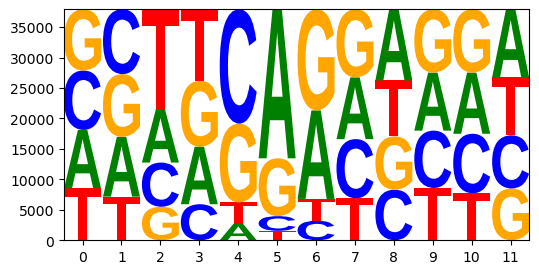

In [81]:
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()

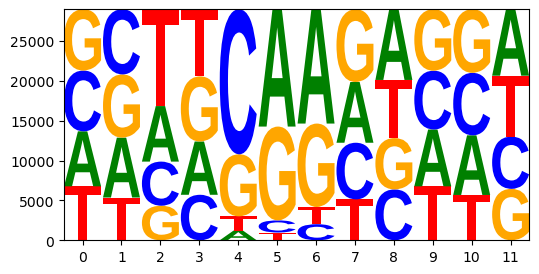

In [82]:
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()

Окрашивание по base_pairing:

In [83]:
# pat_logo = lm.Logo(counts_mat_pat, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# pat_logo.style_xticks()

# ben_logo = lm.Logo(counts_mat_ben, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# ben_logo.style_xticks()

Можно ещё по вероятностям строить:

In [84]:
# prob_mat_pat = lm.transform_matrix(counts_mat_pat, from_type='counts', to_type='probability')
# prob_mat_ben = lm.transform_matrix(counts_mat_ben, from_type='counts', to_type='probability')

### Статистическое сравнение позиций в контекстах

Виды позиционных матриц:  

**Position Frequency Matrix (PFM)**:  
В ячейках PFM содержатся частоты каждого нуклеотида на соответствующей позиции в наборе последовательностей.
PFM не нормализуется по вероятностям, поэтому сумма значений в каждой строке может быть больше 1.  
  
**Position Probability Matrix (PPM)**:  
В отличие от PFM, значения в PPM нормализуются по вероятностям, так что сумма значений в каждой строке равна 1.
PPM показывает вероятность появления каждого нуклеотида на каждой позиции в последовательности.  

**Position Weight Matrix (PWM)**:  
Значения в PWM выражены в виде весов, которые показывают предпочтительность каждого нуклеотида на каждой позиции. Веса обычно вычисляются как логарифм отношения частоты наблюдения нуклеотида к ожидаемой частоте нуклеотида на данной позиции.

Считаем хи-квадраты для каждой позиции при сравнении двух матриц:

In [85]:
def calculate_chi2_p_values(context_ben, context_pat):
    # Преобразование списка контекстов в массив нампай
    sequences_array_ben = np.array(context_ben)
    sequences_array_pat = np.array(context_pat)

    # Создание пустого массива для хранения частот
    freq_array_ben = np.zeros((len(sequences_array_ben[0]), 4))
    freq_array_pat = np.zeros((len(sequences_array_pat[0]), 4))

    # Вычисление частоты каждой буквы на каждой позиции
    for seq in sequences_array_ben:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_ben[j][0] += 1
            elif nt == 'C':
                freq_array_ben[j][1] += 1
            elif nt == 'G':
                freq_array_ben[j][2] += 1
            elif nt == 'T':
                freq_array_ben[j][3] += 1

    for seq in sequences_array_pat:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_pat[j][0] += 1
            elif nt == 'C':
                freq_array_pat[j][1] += 1
            elif nt == 'G':
                freq_array_pat[j][2] += 1
            elif nt == 'T':
                freq_array_pat[j][3] += 1

    chi2_values = []
    p_values = []

    for i in range(freq_array_pat.shape[0]):
        # Таблица сопряженности для каждой текущей позиции (строки в массиве)
        contingency_table = np.array([freq_array_pat[i], freq_array_ben[i]])
        # Два пропуска, т.к. chi2_contingency возвращает statistic, pvalue, dof и expected_freq
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_values.append(chi2)
        p_values.append(p_value)

    return chi2_values, p_values


In [86]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 21.9449616619781, p-value = 6.697398708764799e-05
Position 1: Chi-square = 1.7005812799370346, p-value = 0.6368045715399164
Position 2: Chi-square = 22.112670571957672, p-value = 6.180291538869645e-05
Position 3: Chi-square = 200.3562947764541, p-value = 3.5332677616279874e-43
Position 4: Chi-square = 1242.3907838473328, p-value = 4.652511103787961e-269
Position 5: Chi-square = 1842.562728327588, p-value = 0.0
Position 6: Chi-square = 836.236182210414, p-value = 5.987467978799902e-181
Position 7: Chi-square = 32.55327349455193, p-value = 4.000905664083064e-07
Position 8: Chi-square = 10.660019358699149, p-value = 0.01371377193491875
Position 9: Chi-square = 12.332178572883151, p-value = 0.006327709410487542
Position 10: Chi-square = 17.481044453676468, p-value = 0.0005626768484192643
Position 11: Chi-square = 14.064727160777526, p-value = 0.00281835888341429


In [87]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 20.727591339388827, p-value = 0.0001199186631029316
Position 1: Chi-square = 11.857573186328533, p-value = 0.007887325394329306
Position 2: Chi-square = 8.335742608225447, p-value = 0.039559360472226725
Position 3: Chi-square = 56.18611324911343, p-value = 3.833788359099129e-12
Position 4: Chi-square = 273.1442580807177, p-value = 6.444591832553313e-59
Position 5: Chi-square = 1233.1456967485833, p-value = 4.716428704702979e-267
Position 6: Chi-square = 1787.773602421306, p-value = 0.0
Position 7: Chi-square = 990.753155944817, p-value = 1.8240897470381718e-214
Position 8: Chi-square = 46.853137017728756, p-value = 3.734815990123732e-10
Position 9: Chi-square = 15.637587958824515, p-value = 0.0013454346612928152
Position 10: Chi-square = 8.16822675199392, p-value = 0.04265994658885902
Position 11: Chi-square = 12.470215222502576, p-value = 0.005934320312418849


In [88]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")

Position 0: Chi-square = 8.717495941393189, p-value = 0.033292573730473105
Position 1: Chi-square = 8.11091066063835, p-value = 0.04377427557383811
Position 2: Chi-square = 12.43741349458626, p-value = 0.006025553029404426
Position 3: Chi-square = 3.205929857503626, p-value = 0.3609515040391491
Position 4: Chi-square = 33.6870490634598, p-value = 2.306658852947246e-07
Position 5: Chi-square = 263.7646587309506, p-value = 6.893149852028024e-57
Position 6: Chi-square = 1313.0892264235877, p-value = 2.126742475313406e-284
Position 7: Chi-square = 1750.3950850990138, p-value = 0.0
Position 8: Chi-square = 872.1883921170961, p-value = 9.537605555038618e-189
Position 9: Chi-square = 43.20179151840578, p-value = 2.2298002232071278e-09
Position 10: Chi-square = 24.076355938036755, p-value = 2.4079643483663856e-05
Position 11: Chi-square = 5.264091892742361, p-value = 0.1534494575101868


#### **seqlogo**

https://pypi.org/project/seqlogo/

Можно ещё логотипы строить через библиотеку seqlogo. Но ей нужно подавать уже готовую матрицу (пример выше).

In [89]:
# ppm_pat = seqlogo.Ppm(freq_array_pat)
# ppm_ben = seqlogo.Ppm(freq_array_ben)

# seqlogo.seqlogo(ppm_pat, ic_scale = False, format = 'svg', size = 'medium')
# seqlogo.seqlogo(ppm_ben, ic_scale = False, format = 'svg', size = 'medium')